In [1]:
%matplotlib inline
import librosa, numpy, scipy.linalg, IPython.display as ipd, matplotlib.pyplot as plt
import librosa.display

[&larr; Back to Index](index.html)

# NMF Audio Mosaicing

This notebook is inspired by [the work of Jonathan Driedger, Thomas Prätzlich, and Meinard Müller](https://www.audiolabs-erlangen.de/resources/MIR/2015-ISMIR-LetItBee).

Here is a fun exercise to understand how NMF works. We are going to synthesize an audio signal, $y$, using spectral content from one audio signal, $x_1$, and the NMF temporal activations from another audio signal, $x_2$.

Step 1: Compute the STFT of the first signal, $x_1$:

$$ X_1 \leftarrow \textrm{STFT}(x_1) $$

Step 2: Perform NMF on the second signal, $x_2$, to learn temporal activations while *fixing* the spectral profiles to the magnitude spectrogram, $|X_1|$, learned in step 1:

$$ H \leftarrow \textrm{NMF}(x_2, |X_1|) $$

Step 3: Synthesize an audio signal using $|X_1|$ and $H$:

$$ y \leftarrow \textrm{ISTFT}(|X_1| H) $$

## Step 1: Magnitude Spectrogram of Signal 1

Load the first signal, $x_1$:

In [2]:
x1, sr = librosa.load('audio/simple_loop.wav')

In [3]:
ipd.Audio(x1, rate=sr)

Compute STFT $X_1$, and separate into magnitude and phase:

In [4]:
X1 = librosa.stft(x1)
X1_mag, X1_phase = librosa.magphase(X1)

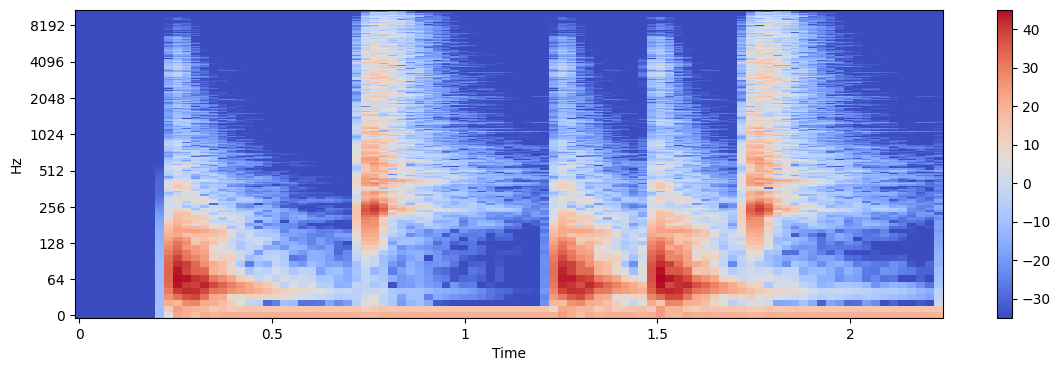

In [5]:
X1_db = librosa.amplitude_to_db(X1_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(X1_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar();

## Step 2: NMF on Signal 2

Load the second signal, $x_2$:

In [6]:
x2, _ = librosa.load('audio/funk_groove.mp3')

In [7]:
ipd.Audio(x2, rate=sr)

Compute STFT $X_2$, and separate into magnitude and phase:

In [8]:
X2 = librosa.stft(x2)
X2_mag, X2_phase = librosa.magphase(X2)

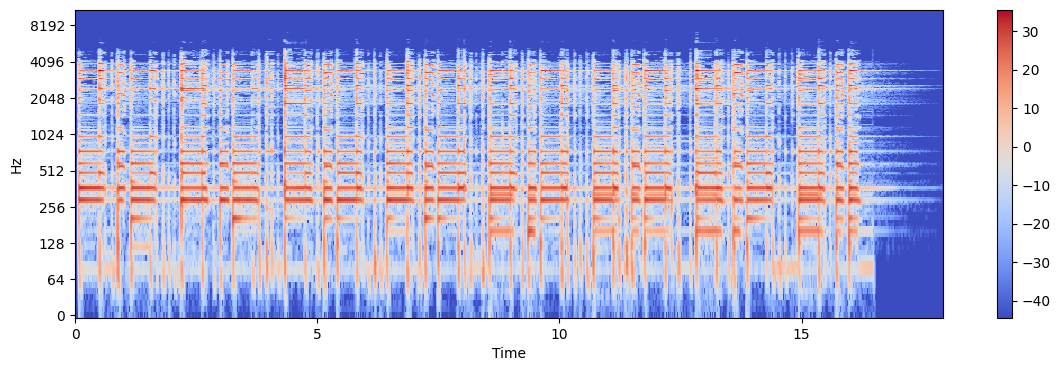

In [9]:
X2_db = librosa.amplitude_to_db(X2_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(X2_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar();

Define $W \triangleq |X_1|$. $W$ will remain fixed.

Perform NMF, but we will only apply an update to $H$, not $W$:

$$ H \leftarrow H \frac{W^T |X_2|}{W^T W H} $$

For this, we will write our own multiplicative update rule that only updates $H$:

In [10]:
# Cache some matrix multiplications.
W = librosa.util.normalize(X1_mag, norm=2, axis=0)
WTX = W.T.dot(X2_mag)
WTW = W.T.dot(W)

# Initialize H.
H = numpy.random.rand(X1.shape[1], X2.shape[1])

# Update H.
eps = 0.01
for _ in range(100):
    H = H*(WTX + eps)/(WTW.dot(H) + eps)

In [11]:
H.shape

(97, 772)

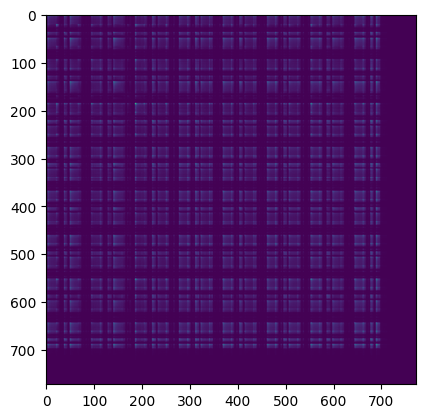

In [12]:
plt.imshow(H.T.dot(H));

## Step 3: Synthesize Output Signal

Synthesize the output signal, $y$, from the spectral components of $x_1$ and the temporal activations (and phase) of $x_2$:

In [13]:
Y_mag = W.dot(H)

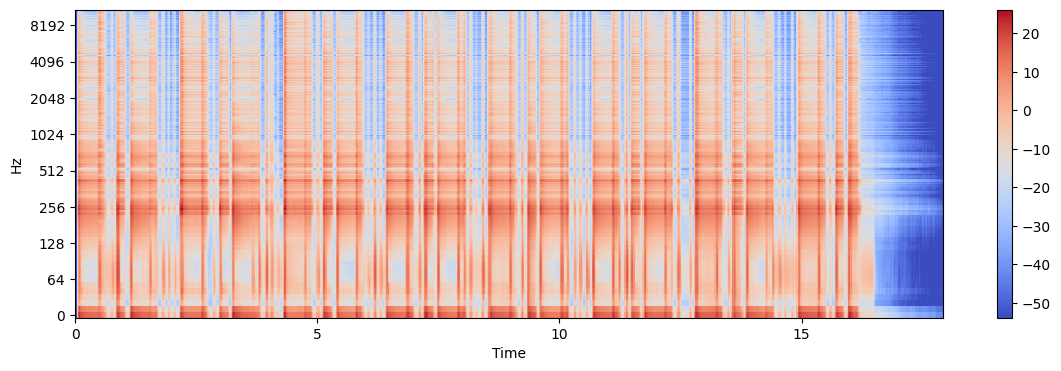

In [14]:
Y_db = librosa.amplitude_to_db(Y_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar();

In [15]:
Y = Y_mag*X2_phase
y = librosa.istft(Y)

In [16]:
ipd.Audio(y, rate=sr)

## Alternate Approach: Sparse Coding

In [17]:
from sklearn.decomposition import SparseCoder

In [18]:
sparse_coder = SparseCoder(X1_mag.T, transform_n_nonzero_coefs=1)

In [19]:
H = sparse_coder.transform(X2_mag.T)

In [20]:
H.shape

(772, 97)

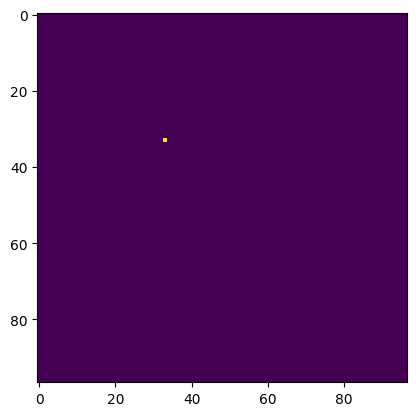

In [21]:
plt.imshow(H.T.dot(H));

In [22]:
Y_mag = W.dot(H.T)

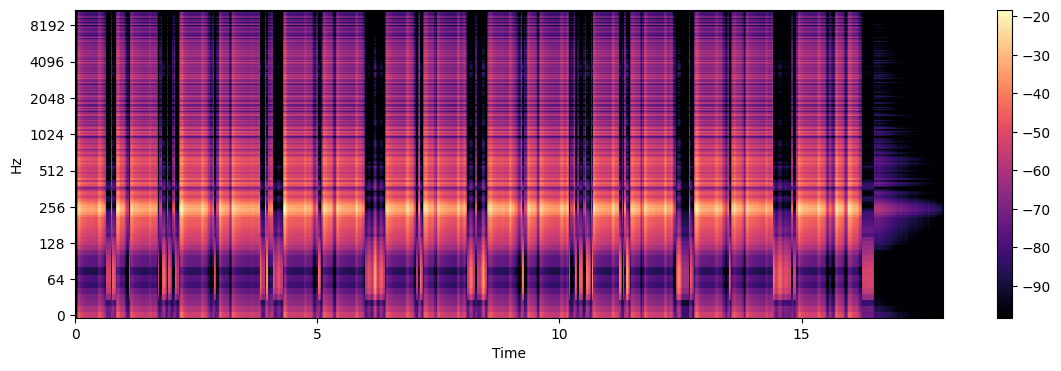

In [23]:
Y_db = librosa.amplitude_to_db(Y_mag)
plt.figure(figsize=(14, 4))
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar();

In [24]:
Y = Y_mag*X2_phase
y = librosa.istft(Y)

In [25]:
ipd.Audio(y, rate=sr)

[&larr; Back to Index](index.html)